Step 1: Custom Environment Code

In [27]:
import numpy as np
import gym
from gym import spaces

class ObstacleAvoidanceEnv(gym.Env):
    def __init__(self, grid_size=10, num_obstacles=5):
        super(ObstacleAvoidanceEnv, self).__init__()
        
        # Grid dimensions
        self.grid_size = grid_size
        
        # Define action and observation space
        self.action_space = spaces.Discrete(4)  # 0: up, 1: down, 2: left, 3: right
        self.observation_space = spaces.Box(low=0, high=grid_size-1, shape=(2,), dtype=np.int32)
        
        # Number of obstacles
        self.num_obstacles = num_obstacles
        
        # Initialize environment
        self.reset()

    def reset(self):
        # Initialize agent position
        self.agent_pos = np.array([0, 0])
        
        # Goal position
        self.goal_pos = np.array([self.grid_size - 1, self.grid_size - 1])
        
        # Randomly place obstacles
        self.obstacles = set()
        while len(self.obstacles) < self.num_obstacles:
            obs = tuple(np.random.randint(0, self.grid_size, size=2))
            if obs != tuple(self.agent_pos) and obs != tuple(self.goal_pos):
                self.obstacles.add(obs)
        
        self.steps = 0
        return self.agent_pos

    def step(self, action):
        # Map actions to movements
        moves = {
            0: np.array([-1, 0]),  # up
            1: np.array([1, 0]),   # down
            2: np.array([0, -1]),  # left
            3: np.array([0, 1])    # right
        }
        
        # Update agent position
        new_pos = self.agent_pos + moves[action]
        
        # Check boundaries
        if 0 <= new_pos[0] < self.grid_size and 0 <= new_pos[1] < self.grid_size:
            self.agent_pos = new_pos
        
        # Check for collisions
        reward = -1  # Default step penalty
        done = False
        if tuple(self.agent_pos) in self.obstacles:
            reward = -10
            done = True
        elif np.array_equal(self.agent_pos, self.goal_pos):
            reward = 100
            done = True
        
        self.steps += 1
        if self.steps >= self.grid_size ** 2:
            done = True  # Timeout
        
        return self.agent_pos, reward, done, {}

    def render(self, mode='human'):
        grid = np.zeros((self.grid_size, self.grid_size), dtype=str)
        grid[:] = '.'
        grid[tuple(self.agent_pos)] = 'A'
        grid[tuple(self.goal_pos)] = 'G'
        for obs in self.obstacles:
            grid[obs] = 'X'
        print("\n".join(["".join(row) for row in grid]))
        print()


Step 2: Test the Environment

In [28]:
env = ObstacleAvoidanceEnv(grid_size=5, num_obstacles=3)

state = env.reset()
done = False

while not done:
    env.render()
    action = env.action_space.sample()  # Take random action
    state, reward, done, info = env.step(action)
    print(f"Action: {action}, Reward: {reward}, State: {state}")


A....
...X.
..X..
X....
....G

Action: 3, Reward: -1, State: [0 1]
.A...
...X.
..X..
X....
....G

Action: 1, Reward: -1, State: [1 1]
.....
.A.X.
..X..
X....
....G

Action: 2, Reward: -1, State: [1 0]
.....
A..X.
..X..
X....
....G

Action: 3, Reward: -1, State: [1 1]
.....
.A.X.
..X..
X....
....G

Action: 2, Reward: -1, State: [1 0]
.....
A..X.
..X..
X....
....G

Action: 1, Reward: -1, State: [2 0]
.....
...X.
A.X..
X....
....G

Action: 3, Reward: -1, State: [2 1]
.....
...X.
.AX..
X....
....G

Action: 2, Reward: -1, State: [2 0]
.....
...X.
A.X..
X....
....G

Action: 1, Reward: -10, State: [3 0]


Step 3: Q-Learning Implementation

Episode 50/1000: Total Reward = -10.0, Epsilon = 0.605
Episode 100/1000: Total Reward = -25.0, Epsilon = 0.366
Episode 150/1000: Total Reward = -13.0, Epsilon = 0.221
Episode 200/1000: Total Reward = 86.0, Epsilon = 0.134
Episode 250/1000: Total Reward = -16.0, Epsilon = 0.081
Episode 300/1000: Total Reward = -14.0, Epsilon = 0.049
Episode 350/1000: Total Reward = -11.0, Epsilon = 0.030
Episode 400/1000: Total Reward = -11.0, Epsilon = 0.018
Episode 450/1000: Total Reward = 93.0, Epsilon = 0.011
Episode 500/1000: Total Reward = 93.0, Epsilon = 0.010
Episode 550/1000: Total Reward = 93.0, Epsilon = 0.010
Episode 600/1000: Total Reward = -10.0, Epsilon = 0.010
Episode 650/1000: Total Reward = -10.0, Epsilon = 0.010
Episode 700/1000: Total Reward = 93.0, Epsilon = 0.010
Episode 750/1000: Total Reward = -10.0, Epsilon = 0.010
Episode 800/1000: Total Reward = -11.0, Epsilon = 0.010
Episode 850/1000: Total Reward = 93.0, Epsilon = 0.010
Episode 900/1000: Total Reward = -10.0, Epsilon = 0.010

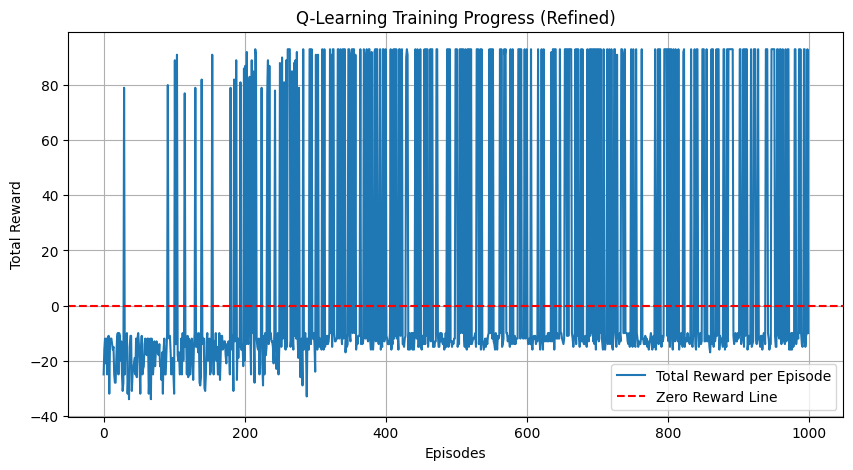

In [29]:
# Import necessary libraries
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt

# Define the custom environment
class ObstacleAvoidanceEnv(gym.Env):
    def __init__(self, grid_size=10, num_obstacles=5):
        super(ObstacleAvoidanceEnv, self).__init__()
        
        # Grid dimensions
        self.grid_size = grid_size
        
        # Define action and observation space
        self.action_space = spaces.Discrete(4)  # 0: up, 1: down, 2: left, 3: right
        self.observation_space = spaces.Box(low=0, high=grid_size - 1, shape=(2,), dtype=np.int32)
        
        # Number of obstacles
        self.num_obstacles = num_obstacles
        
        # Initialize the environment
        self.reset()

    def reset(self):
        # Initialize agent position
        self.agent_pos = np.array([0, 0])
        
        # Goal position
        self.goal_pos = np.array([self.grid_size - 1, self.grid_size - 1])
        
        # Randomly place obstacles
        self.obstacles = set()
        while len(self.obstacles) < self.num_obstacles:
            obs = tuple(np.random.randint(0, self.grid_size, size=2))
            if obs != tuple(self.agent_pos) and obs != tuple(self.goal_pos):
                self.obstacles.add(obs)
        
        self.steps = 0
        return self.agent_pos

    def step(self, action):
        # Map actions to movements
        moves = {0: np.array([-1, 0]),  # up
                 1: np.array([1, 0]),   # down
                 2: np.array([0, -1]),  # left
                 3: np.array([0, 1])}   # right
        
        # Update agent position
        new_pos = self.agent_pos + moves[action]
        
        # Default reward and done status
        reward = -0.1  # Step penalty
        done = False

        # Check boundaries
        if not (0 <= new_pos[0] < self.grid_size and 0 <= new_pos[1] < self.grid_size):
            reward = -2  # Boundary penalty
        else:
            self.agent_pos = new_pos
            
            # Check for collisions
            if tuple(self.agent_pos) in self.obstacles:
                reward = -10  # Collision penalty
                done = True
            elif np.array_equal(self.agent_pos, self.goal_pos):
                reward = 100  # Goal reward
                done = True

        # Increment step count and check for timeout
        self.steps += 1
        if self.steps >= self.grid_size ** 2:  # Timeout condition
            done = True

        return self.agent_pos, reward, done, {}

    def render(self, mode='human'):
        grid = np.zeros((self.grid_size, self.grid_size), dtype=str)
        grid[:] = '.'
        grid[tuple(self.agent_pos)] = 'A'
        grid[tuple(self.goal_pos)] = 'G'
        for obs in self.obstacles:
            grid[obs] = 'X'
        print("\n".join(["".join(row) for row in grid]))
        print()

def q_learning(env, episodes=1000, alpha=0.05, gamma=0.99, epsilon=1.0, epsilon_decay=0.99, epsilon_min=0.01):
    q_table = np.zeros((env.grid_size, env.grid_size, env.action_space.n))
    rewards_per_episode = []

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            # Epsilon-greedy action selection
            if np.random.rand() < epsilon:
                action = env.action_space.sample()  # Random action
            else:
                action = np.argmax(q_table[state[0], state[1]])  # Best action

            # Take action, observe the outcome
            next_state, reward, done, _ = env.step(action)

            # Update Q-value using the Bellman equation
            old_value = q_table[state[0], state[1], action]
            next_max = np.max(q_table[next_state[0], next_state[1]])
            q_table[state[0], state[1], action] = old_value + alpha * (reward + gamma * next_max - old_value)

            # Update state and accumulate reward
            state = next_state
            total_reward += reward

        # Decay epsilon
        epsilon = max(epsilon * epsilon_decay, epsilon_min)

        # Log total reward
        rewards_per_episode.append(total_reward)

        # Print progress periodically
        if (episode + 1) % 50 == 0:
            print(f"Episode {episode + 1}/{episodes}: Total Reward = {total_reward:.1f}, Epsilon = {epsilon:.3f}")

    return q_table, rewards_per_episode

# Train the agent with the refined hyperparameters
q_table, rewards = q_learning(env)

# Plot rewards over episodes
plt.figure(figsize=(10, 5))
plt.plot(rewards, label="Total Reward per Episode")
plt.axhline(0, color='red', linestyle='--', label="Zero Reward Line")
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Q-Learning Training Progress (Refined)')
plt.legend()
plt.grid()
plt.show()



Step 1: Implement DQN (Deep Q-Network)

Episode 50/1000, Total Reward: -15.00, Epsilon: 0.126
Episode 100/1000, Total Reward: 89.00, Epsilon: 0.030
Episode 150/1000, Total Reward: -15.00, Epsilon: 0.010
Episode 200/1000, Total Reward: 90.50, Epsilon: 0.010
Episode 250/1000, Total Reward: 90.50, Epsilon: 0.010
Episode 300/1000, Total Reward: -19.50, Epsilon: 0.010
Episode 350/1000, Total Reward: -19.50, Epsilon: 0.010
Episode 400/1000, Total Reward: -15.00, Epsilon: 0.010
Episode 450/1000, Total Reward: -19.50, Epsilon: 0.010
Episode 500/1000, Total Reward: -12.00, Epsilon: 0.010
Episode 550/1000, Total Reward: -13.50, Epsilon: 0.010
Episode 600/1000, Total Reward: 90.50, Epsilon: 0.010
Episode 650/1000, Total Reward: -15.00, Epsilon: 0.010
Episode 700/1000, Total Reward: -12.00, Epsilon: 0.010
Episode 750/1000, Total Reward: 90.50, Epsilon: 0.010
Episode 800/1000, Total Reward: 90.50, Epsilon: 0.010
Episode 850/1000, Total Reward: -19.50, Epsilon: 0.010
Episode 900/1000, Total Reward: -19.50, Epsilon: 0.010
Episode 950/1000,

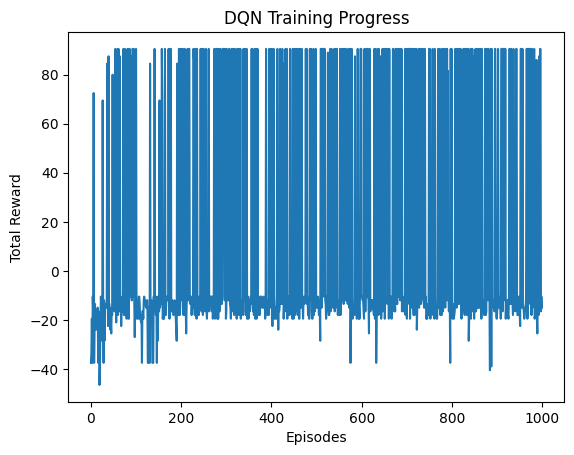

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

# Define the DQN model
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)  # Increased size
        self.fc2 = nn.Linear(512, 256)  # Increased size
        self.fc3 = nn.Linear(256, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the DQN agent with more modifications
class DQNAgent:
    def __init__(self, env, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995, gamma=0.99, alpha=0.0005, batch_size=64, memory_size=10000):
        self.env = env
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        self.model = DQN(env.observation_space.shape[0], env.action_space.n)
        self.target_model = DQN(env.observation_space.shape[0], env.action_space.n)
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=alpha)
        self.loss_fn = nn.MSELoss()

    def store_experience(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return self.env.action_space.sample()  # Random action
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.model(state)
        return torch.argmax(q_values).item()

    def train(self):
        if len(self.memory) < self.batch_size:
            return

        # Sample a random batch of experiences from memory
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.BoolTensor(dones).unsqueeze(1)

        # Get Q-values for current states
        q_values = self.model(states).gather(1, actions)

        # Double Q-Learning: Use the main model to select the action and the target model for value estimation
        with torch.no_grad():
            next_actions = self.model(next_states).max(1)[1].unsqueeze(1)  # Get best action using the main model
            next_q_values = self.target_model(next_states).gather(1, next_actions)

        # Calculate target
        target = rewards + (1 - dones.float()) * self.gamma * next_q_values

        # Compute loss
        loss = self.loss_fn(q_values, target)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update epsilon gradually
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

# Training loop with enhanced reward shaping and more stable updates
def dqn_train(env, episodes=1000, agent=None):
    rewards_per_episode = []
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            
            # Enhanced reward shaping
            if reward > 0:
                reward += 1.0  # Larger bonus for positive actions
            elif reward < 0:
                reward -= 0.5  # Slight penalty for negative actions

            agent.store_experience(state, action, reward, next_state, done)
            agent.train()

            total_reward += reward
            state = next_state

        # Update target model periodically (every 10 episodes)
        if episode % 10 == 0:
            agent.update_target_model()

        rewards_per_episode.append(total_reward)

        if (episode + 1) % 50 == 0:
            print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.3f}")

    return rewards_per_episode

# Assuming the environment is already created (env)
# Initialize and train DQN agent
dqn_agent = DQNAgent(env)
dqn_rewards = dqn_train(env, episodes=1000, agent=dqn_agent)

# Plot rewards for DQN
plt.plot(dqn_rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('DQN Training Progress')
plt.show()


Step 2: Implement DDQN (Double Deep Q-Network)

In [31]:
class DDQNAgent(DQNAgent):
    def __init__(self, env, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995, gamma=0.99, alpha=0.001, batch_size=32, memory_size=10000):
        super(DDQNAgent, self).__init__(env, epsilon, epsilon_min, epsilon_decay, gamma, alpha, batch_size, memory_size)

    def train(self):
        if len(self.memory) < self.batch_size:
            return

        # Sample a random batch of experiences from memory
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.BoolTensor(dones).unsqueeze(1)

        # Get Q-values for current states
        q_values = self.model(states).gather(1, actions)

        # Get action for next states using the main network
        with torch.no_grad():
            next_actions = self.model(next_states).max(1, keepdim=True)[1]
            next_q_values = self.target_model(next_states).gather(1, next_actions)

        # Calculate target
        target = rewards + (1 - dones) * self.gamma * next_q_values

        # Compute loss
        loss = self.loss_fn(q_values, target)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    # No need to update the target model periodically in DDQN as we use the target network for evaluation
    # It's still a good practice to occasionally update it, though.


Step 5: Implement Dueling Deep Q-Network (Dueling DQN)

Episode 50/1000, Total Reward: -25, Epsilon: 0.778
Episode 100/1000, Total Reward: -11, Epsilon: 0.606
Episode 150/1000, Total Reward: -11, Epsilon: 0.471
Episode 200/1000, Total Reward: 93, Epsilon: 0.367
Episode 250/1000, Total Reward: 91, Epsilon: 0.286
Episode 300/1000, Total Reward: 93, Epsilon: 0.222
Episode 350/1000, Total Reward: 93, Epsilon: 0.173
Episode 400/1000, Total Reward: 93, Epsilon: 0.135
Episode 450/1000, Total Reward: 93, Epsilon: 0.105
Episode 500/1000, Total Reward: -11, Epsilon: 0.082
Episode 550/1000, Total Reward: -14, Epsilon: 0.063
Episode 600/1000, Total Reward: -11, Epsilon: 0.049
Episode 650/1000, Total Reward: 93, Epsilon: 0.038
Episode 700/1000, Total Reward: -16, Epsilon: 0.030
Episode 750/1000, Total Reward: 93, Epsilon: 0.023
Episode 800/1000, Total Reward: 93, Epsilon: 0.018
Episode 850/1000, Total Reward: -10, Epsilon: 0.014
Episode 900/1000, Total Reward: -15, Epsilon: 0.011
Episode 950/1000, Total Reward: 93, Epsilon: 0.010
Episode 1000/1000, Tota

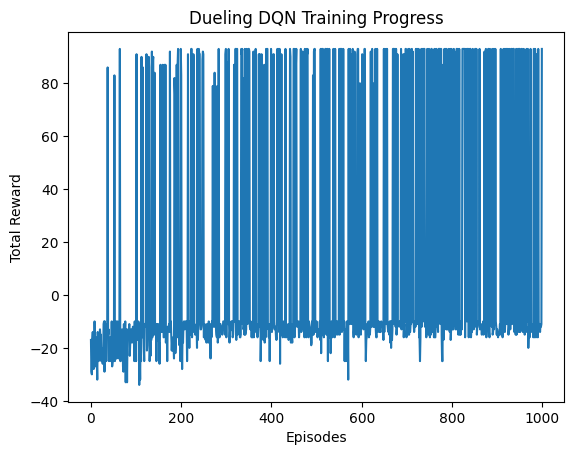

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class DuelingDQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DuelingDQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)

        # Value stream (V(s))
        self.value_fc = nn.Linear(64, 1)

        # Advantage stream (A(s, a))
        self.advantage_fc = nn.Linear(64, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        value = self.value_fc(x)
        advantage = self.advantage_fc(x)

        # Final Q-value = Value + (Advantage - mean(Advantage))
        return value + (advantage - advantage.mean())

class DQNAgent:
    def __init__(self, env, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995, gamma=0.98, alpha=0.001, batch_size=64, memory_size=20000):
        self.env = env
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma
        self.alpha = alpha
        self.batch_size = batch_size
        self.memory_size = memory_size
        self.memory = []
        self.model = DuelingDQN(env.observation_space.shape[0], env.action_space.n)
        self.target_model = DuelingDQN(env.observation_space.shape[0], env.action_space.n)
        self.target_model.load_state_dict(self.model.state_dict())
        self.loss_fn = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.alpha)

    def store_experience(self, state, action, reward, next_state, done):
        if len(self.memory) >= self.memory_size:
            self.memory.pop(0)
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                q_values = self.model(state)
                return torch.argmax(q_values, dim=1).item()

    def train(self):
        if len(self.memory) < self.batch_size:
            return

        batch = np.random.choice(len(self.memory), self.batch_size)
        states, actions, rewards, next_states, dones = zip(*[self.memory[idx] for idx in batch])

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64).view(-1, 1)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.bool)

        q_values = self.model(states).gather(1, actions)

        # Double DQN: Use the target network to select the next action
        next_actions = self.model(next_states).argmax(1).unsqueeze(1)
        next_q_values = self.target_model(next_states).gather(1, next_actions).squeeze()

        target = rewards + (1 - dones.float()) * self.gamma * next_q_values

        loss = self.loss_fn(q_values.squeeze(), target)

        self.model.zero_grad()
        loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1)

        self.optimizer.step()

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

def dueling_dqn_train(env, episodes=1000, agent=None):
    rewards_per_episode = []
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.store_experience(state, action, reward, next_state, done)
            agent.train()

            total_reward += reward
            state = next_state

        agent.decay_epsilon()

        # Update target model more frequently (every 5 episodes)
        if episode % 5 == 0:
            agent.update_target_model()

        rewards_per_episode.append(total_reward)

        # Print progress
        if (episode + 1) % 50 == 0:
            print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.3f}")

    return rewards_per_episode

# Initialize and train Dueling DQN agent with updated settings
dueling_dqn_agent = DQNAgent(env, epsilon_decay=0.995, gamma=0.98, alpha=0.001, batch_size=64)
dueling_dqn_rewards = dueling_dqn_train(env, episodes=1000, agent=dueling_dqn_agent)

# Plot rewards for Dueling DQN
plt.plot(dueling_dqn_rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Dueling DQN Training Progress')
plt.show()


Step 6: Prioritized Experience Replay

C:\Users\dhira\AppData\Local\Temp\ipykernel_23876\4060522906.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.priorities[idx] = max(float(td_error), 1e-5)


Episode 50/1000, Total Reward: -25, Epsilon: 0.100
Episode 100/1000, Total Reward: -25, Epsilon: 0.100
Episode 150/1000, Total Reward: -30, Epsilon: 0.100
Episode 200/1000, Total Reward: -26, Epsilon: 0.100
Episode 250/1000, Total Reward: -25, Epsilon: 0.100
Episode 300/1000, Total Reward: -25, Epsilon: 0.100
Episode 350/1000, Total Reward: -25, Epsilon: 0.100
Episode 400/1000, Total Reward: -25, Epsilon: 0.100
Episode 450/1000, Total Reward: -25, Epsilon: 0.100
Episode 500/1000, Total Reward: -25, Epsilon: 0.100
Episode 550/1000, Total Reward: -25, Epsilon: 0.100
Episode 600/1000, Total Reward: -10, Epsilon: 0.100
Episode 650/1000, Total Reward: -13, Epsilon: 0.100
Episode 700/1000, Total Reward: -25, Epsilon: 0.100
Episode 750/1000, Total Reward: -11, Epsilon: 0.100
Episode 800/1000, Total Reward: -25, Epsilon: 0.100
Episode 850/1000, Total Reward: -25, Epsilon: 0.100
Episode 900/1000, Total Reward: -25, Epsilon: 0.100
Episode 950/1000, Total Reward: -27, Epsilon: 0.100
Episode 1000/

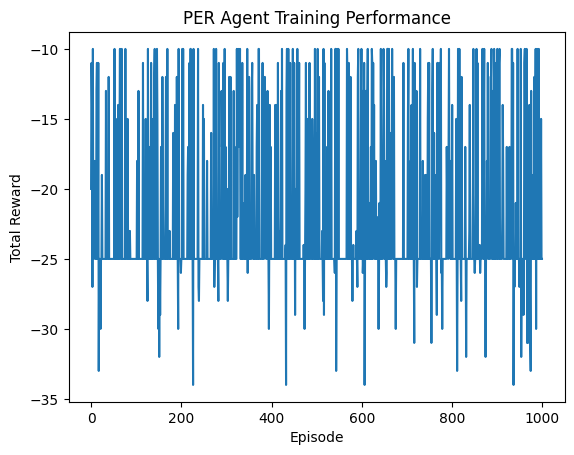

In [33]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from collections import deque
import random
import torch.nn.functional as F

class PrioritizedReplayBuffer:
    def __init__(self, capacity=10000, alpha=0.6, beta=0.4, beta_increment_per_sampling=0.001):
        self.capacity = capacity
        self.alpha = alpha
        self.beta = beta
        self.beta_increment_per_sampling = beta_increment_per_sampling
        self.buffer = deque(maxlen=capacity)
        self.priorities = deque(maxlen=capacity)

    def store(self, experience):
        self.buffer.append(experience)
        if len(self.priorities) == 0:
            max_priority = 1.0
        else:
            max_priority = max(self.priorities)
        self.priorities.append(float(max_priority))

    def sample(self, batch_size):
        if len(self.buffer) == 0:
            return [], [], []
        
        priorities = np.array(self.priorities, dtype=np.float32) ** self.alpha
        priorities = np.nan_to_num(priorities, nan=1.0, posinf=1.0, neginf=1.0)
        
        probabilities = priorities / priorities.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probabilities)
        
        batch = [self.buffer[idx] for idx in indices]
        weights = (len(self.buffer) * probabilities[indices]) ** (-self.beta)
        weights /= weights.max()
        
        self.beta = min(1.0, self.beta + self.beta_increment_per_sampling)

        return batch, weights, indices

    def update_priorities(self, indices, td_errors):
        for idx, td_error in zip(indices, td_errors):
            self.priorities[idx] = max(float(td_error), 1e-5)

class DQNAgent:
    def __init__(self, env, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995, gamma=0.99, alpha=0.0005, batch_size=32, memory_size=10000):
        self.env = env
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma
        self.alpha = alpha
        self.batch_size = batch_size
        self.memory_size = memory_size
        self.memory = PrioritizedReplayBuffer(memory_size)
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.alpha)

    def build_model(self):
        model = torch.nn.Sequential(
            torch.nn.Linear(self.env.observation_space.shape[0], 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, self.env.action_space.n)
        )
        return model

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()  # Random action
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.model(state)
        return q_values.argmax().item()

    def store_experience(self, state, action, reward, next_state, done):
        self.memory.store((state, action, reward, next_state, done))

    def train(self):
        if len(self.memory.buffer) < self.batch_size:
            return

        batch, weights, indices = self.memory.sample(self.batch_size)
        if not batch:
            return

        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.BoolTensor(dones).unsqueeze(1)
        weights = torch.FloatTensor(weights).unsqueeze(1)

        dones = dones.float()

        q_values = self.model(states).gather(1, actions)
        with torch.no_grad():
            next_q_values = self.target_model(next_states).max(1, keepdim=True)[0]
        
        target = rewards + (1 - dones) * self.gamma * next_q_values

        loss = F.smooth_l1_loss(q_values, target)

        self.optimizer.zero_grad()
        loss.backward()

        # Clip gradients to prevent instability
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

        self.optimizer.step()

        td_errors = (q_values - target).detach().numpy()
        self.memory.update_priorities(indices, td_errors)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        self.target_model.load_state_dict(self.model.state_dict())

# Training loop for PER Agent
def per_train(env, episodes=1000, agent=None):
    rewards_per_episode = []
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.store_experience(state, action, reward, next_state, done)
            agent.train()

            total_reward += reward
            state = next_state

        rewards_per_episode.append(total_reward)

        # Print reward every 50 episodes and monitor epsilon
        if (episode + 1) % 50 == 0:
            print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.3f}")

    return rewards_per_episode

# Initialize and train PER agent
per_agent = DQNAgent(env, epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.995, gamma=0.99, alpha=0.0005, batch_size=32, memory_size=10000)
per_rewards = per_train(env, episodes=1000, agent=per_agent)

# Plot rewards for PER
plt.plot(per_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('PER Agent Training Performance')
plt.show()


Step 7: Evaluation and Comparison

In [34]:
class DDQNAgent(DQNAgent):
    def __init__(self, env, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995, gamma=0.99, alpha=0.001, batch_size=32, memory_size=10000):
        super(DDQNAgent, self).__init__(env, epsilon, epsilon_min, epsilon_decay, gamma, alpha, batch_size, memory_size)
        self.model = DQN(env.observation_space.shape[0], env.action_space.n)  # Same as DQN model
        self.target_model = DQN(env.observation_space.shape[0], env.action_space.n)  # Target model
        self.target_model.load_state_dict(self.model.state_dict())

    def train(self):
        if len(self.memory.buffer) < self.batch_size:
            return

        # Sample a batch
        batch, weights, indices = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.BoolTensor(dones).unsqueeze(1)
        weights = torch.FloatTensor(weights).unsqueeze(1)

        # Get Q-values for current states
        q_values = self.model(states).gather(1, actions)

        # DDQN: Use the online model to select actions, and the target model to evaluate them
        with torch.no_grad():
            next_actions = self.model(next_states).max(1)[1].unsqueeze(1)  # Best actions from the online model
            next_q_values = self.target_model(next_states).gather(1, next_actions)  # Evaluate with target model

        # Calculate target Q-values
        target = rewards + (1 - dones) * self.gamma * next_q_values

        # Compute loss and optimize
        loss = (weights * (q_values - target) ** 2).mean()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update priorities in PER
        td_errors = (q_values - target).detach().numpy()
        self.memory.update_priorities(indices, td_errors)

        # Update epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())


# Initialize DDQN agent
ddqn_agent = DDQNAgent(env)

def evaluate_agent(env, agent, episodes=100):
    total_rewards = []
    
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            state = next_state
        
        total_rewards.append(total_reward)
    
    avg_reward = np.mean(total_rewards)
    return avg_reward


# Now, you can proceed with the evaluation code:
dqn_avg_reward = evaluate_agent(env, dqn_agent)
ddqn_avg_reward = evaluate_agent(env, ddqn_agent)  # Now ddqn_agent is defined
dueling_dqn_avg_reward = evaluate_agent(env, dueling_dqn_agent)
per_avg_reward = evaluate_agent(env, per_agent)

print(f"DQN Average Reward: {dqn_avg_reward}")
print(f"DDQN Average Reward: {ddqn_avg_reward}")
print(f"Dueling DQN Average Reward: {dueling_dqn_avg_reward}")
print(f"PER Average Reward: {per_avg_reward}")


DQN Average Reward: 23.17
DDQN Average Reward: -17.35
Dueling DQN Average Reward: 23.41
PER Average Reward: -24.95


# now all the agent is being initialized now we will train the agents 

1. Training the agents

In [36]:
import collections
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Define the Q-network model
class QNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# DQN Agent with experience replay
class DQNAgent:
    def __init__(self, env, epsilon=0.1, batch_size=32, gamma=0.99, learning_rate=0.001):
        self.env = env
        self.memory = collections.deque(maxlen=2000)
        self.epsilon = epsilon  # Epsilon for epsilon-greedy action selection
        self.batch_size = batch_size
        self.gamma = gamma  # Discount factor for future rewards
        self.learning_rate = learning_rate  # Learning rate for the optimizer
        
        # Initialize the Q-network (main model)
        self.model = QNetwork(env.observation_space.shape[0], env.action_space.n)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.MSELoss()

    def store_experience(self, state, action, reward, next_state, done):
        """Store experience in memory"""
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        """Epsilon-greedy policy for action selection"""
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
        if np.random.rand() < self.epsilon:
            # Random action (exploration)
            return self.env.action_space.sample()
        else:
            # Choose action based on current Q-values (exploitation)
            q_values = self.model(state)
            action = torch.argmax(q_values).item()
            return action

    def train(self):
        """Train the model using experiences from the replay buffer"""
        if len(self.memory) < self.batch_size:
            return  # Not enough experience to train
        
        # Sample a batch of experiences from memory
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.bool)
        
        # Get predicted Q-values from the main model
        q_values = self.model(states)
        predicted_q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Compute the target Q-values using the Bellman equation
        with torch.no_grad():
            next_q_values = self.model(next_states).max(1)[0]
            target_q_values = rewards + (self.gamma * next_q_values * (~dones))
        
        # Compute the loss (mean squared error)
        loss = self.loss_fn(predicted_q_values, target_q_values)
        
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

# Dueling DQN Agent
class DuelingDQNAgent(DQNAgent):
    def __init__(self, env, epsilon=0.1, batch_size=32, gamma=0.99, learning_rate=0.001):
        super(DuelingDQNAgent, self).__init__(env, epsilon, batch_size, gamma, learning_rate)
        
        # Dueling Q-network architecture (share the feature extraction part)
        self.fc1 = nn.Linear(env.observation_space.shape[0], 128)
        self.value_fc = nn.Linear(128, 1)  # Value stream
        self.advantage_fc = nn.Linear(128, env.action_space.n)  # Advantage stream
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        value = self.value_fc(x)
        advantage = self.advantage_fc(x)
        q_values = value + (advantage - advantage.mean())
        return q_values

# Train the agent
def train_agent(agent, episodes=500):
    rewards = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            
            # Store experience in memory
            agent.store_experience(state, action, reward, next_state, done)
            
            # Update agent based on the stored experiences
            agent.train()
            
            state = next_state
            total_reward += reward
        
        rewards.append(total_reward)
        
        # Print progress every 50 episodes
        if (episode + 1) % 50 == 0:
            print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")
    
    return rewards


# Initialize the environment
env = ObstacleAvoidanceEnv(grid_size=5, num_obstacles=3)  # Assuming the environment is already set up

# Initialize DQN and Dueling DQN agents
dqn_agent = DQNAgent(env)  # DQN agent initialized
dueling_dqn_agent = DuelingDQNAgent(env)  # Dueling DQN agent initialized

# Train both agents
dqn_rewards = train_agent(dqn_agent)
dueling_dqn_rewards = train_agent(dueling_dqn_agent)


Episode 50/500, Total Reward: 99.3
Episode 100/500, Total Reward: -10
Episode 150/500, Total Reward: -10.1
Episode 200/500, Total Reward: -36.7
Episode 250/500, Total Reward: 99.3
Episode 300/500, Total Reward: -10.6
Episode 350/500, Total Reward: -10.6
Episode 400/500, Total Reward: 99.3
Episode 450/500, Total Reward: -10.1
Episode 500/500, Total Reward: 99.1
Episode 50/500, Total Reward: -10
Episode 100/500, Total Reward: -10.4
Episode 150/500, Total Reward: -10.6
Episode 200/500, Total Reward: -10.6
Episode 250/500, Total Reward: -10.2
Episode 300/500, Total Reward: 99.3
Episode 350/500, Total Reward: 99.1
Episode 400/500, Total Reward: -10.2
Episode 450/500, Total Reward: 98.9
Episode 500/500, Total Reward: 99.1


In [38]:
import torch
import torch.nn as nn
import torch.optim as optim

class DDQNAgent:
    def __init__(self, env):
        self.env = env
        self.action_space = env.action_space
        self.state_space = env.observation_space
        
        # Initialize model and target model
        self.model = self.build_model()  # Main model (online model)
        self.target_model = self.build_model()  # Target model for Double DQN
        
        # Print statements to check model initialization
        print("Model Initialized: ", self.model)
        print("Target Model Initialized: ", self.target_model)
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.loss_fn = nn.MSELoss()

    def build_model(self):
        # Define a simple neural network model for Q-value approximation
        model = nn.Sequential(
            nn.Linear(self.state_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, self.action_space.n)
        )
        return model

    def act(self, state):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        q_values = self.model(state)
        action = torch.argmax(q_values).item()
        return action

    def train(self):
        # Training logic for DDQN (adjust based on your use case)
        pass



2. Evaluating the Agents

In [39]:
# Evaluate each agent
dqn_avg_reward = evaluate_agent(env, dqn_agent)
dueling_dqn_avg_reward = evaluate_agent(env, dueling_dqn_agent)

print(f"DQN Average Reward: {dqn_avg_reward}")
print(f"Dueling DQN Average Reward: {dueling_dqn_avg_reward}")


DQN Average Reward: -7.052
Dueling DQN Average Reward: -5.865


3. Plotting Rewards

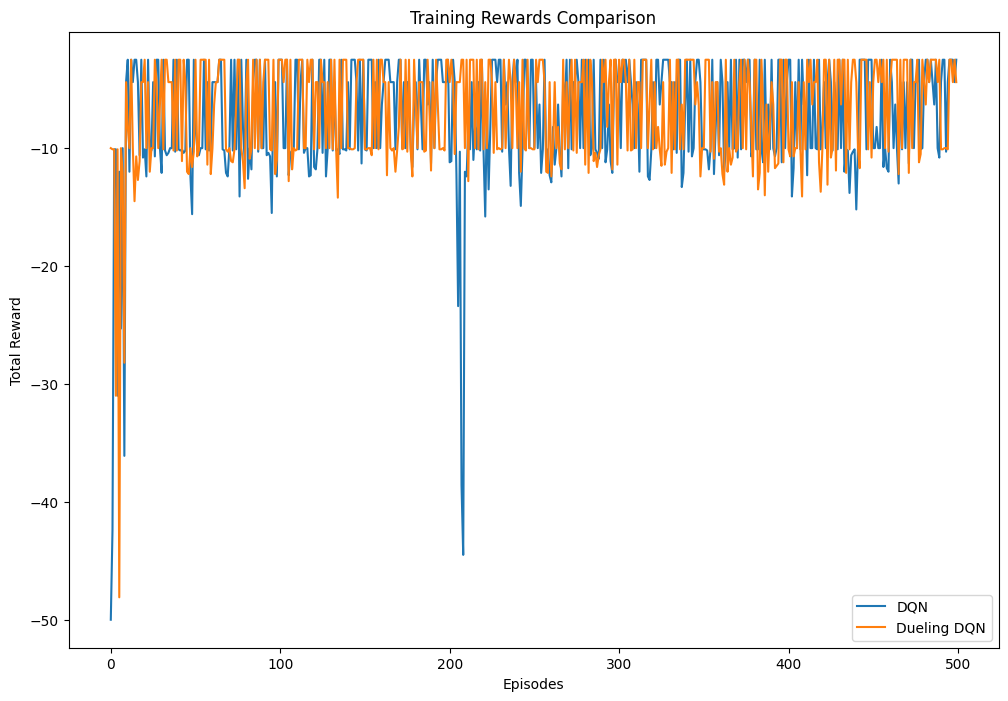

In [40]:
import matplotlib.pyplot as plt

# Plot rewards for each agent
plt.figure(figsize=(12, 8))
plt.plot(dqn_rewards, label='DQN')
plt.plot(dueling_dqn_rewards, label='Dueling DQN')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Training Rewards Comparison')
plt.legend()
plt.show()


4. Saving and Loading Models

In [41]:
# Save the models
torch.save(dqn_agent.model.state_dict(), 'dqn_model.pth')
torch.save(dueling_dqn_agent.model.state_dict(), 'dueling_dqn_model.pth')


# Load the models later
dqn_agent.model.load_state_dict(torch.load('dqn_model.pth'))
dueling_dqn_agent.model.load_state_dict(torch.load('dueling_dqn_model.pth'))



C:\Users\dhira\AppData\Local\Temp\ipykernel_23876\3188262414.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dqn_agent.model.load_state_dict(torch.load('dqn_model.pth'))

<All keys matched successfully>

# Now visualizing the game

Option 1: Using matplotlib to Plot Agent's Path

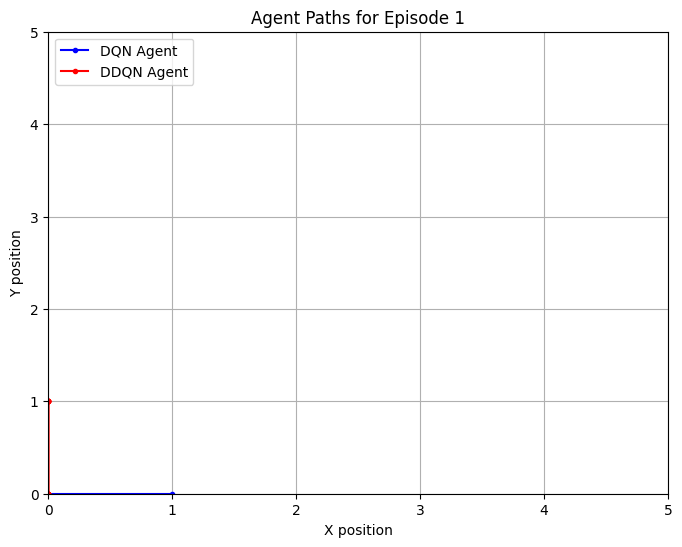

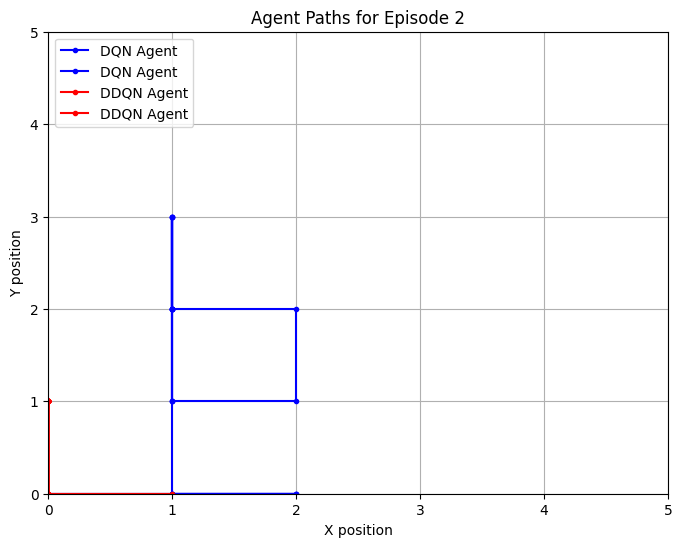

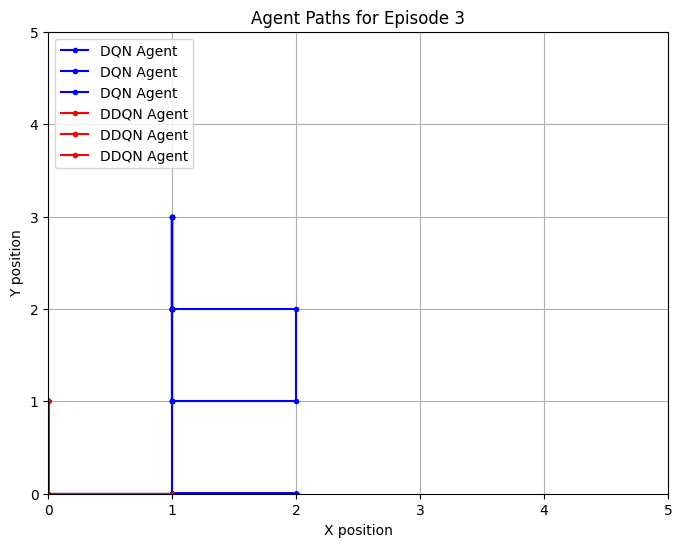

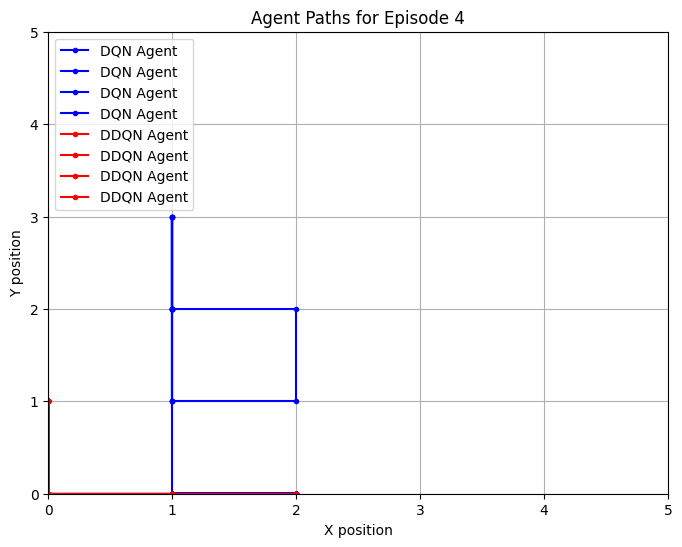

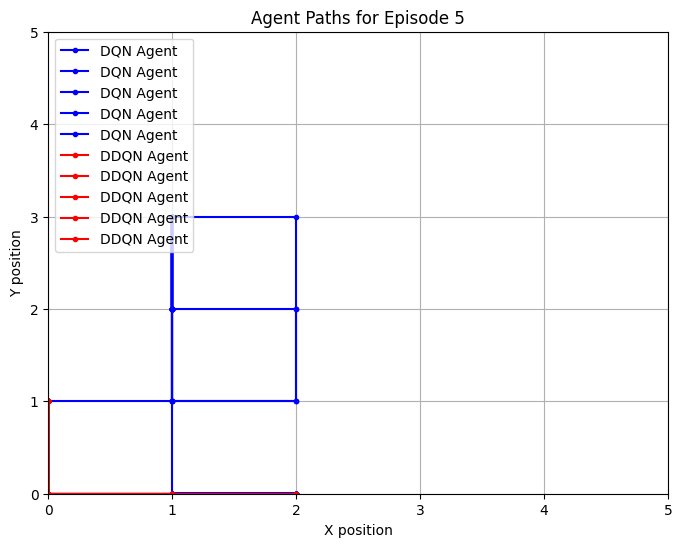

In [42]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_training_progress(env, dqn_agent, ddqn_agent, episodes=100):
    # Track the paths of both agents across multiple episodes
    dqn_paths = []
    ddqn_paths = []
    
    for episode in range(episodes):
        # DQN agent episode path
        dqn_state = env.reset()
        dqn_episode_path = []  # Track DQN agent's path
        dqn_done = False
        
        while not dqn_done:
            dqn_action = dqn_agent.act(dqn_state)
            dqn_next_state, reward, dqn_done, _ = env.step(dqn_action)
            
            dqn_episode_path.append(dqn_state)  # Track DQN agent's position
            dqn_state = dqn_next_state
        
        dqn_paths.append(np.array(dqn_episode_path))  # Store DQN path
        
        # DDQN agent episode path
        ddqn_state = env.reset()
        ddqn_episode_path = []  # Track DDQN agent's path
        ddqn_done = False
        
        while not ddqn_done:
            ddqn_action = ddqn_agent.act(ddqn_state)
            ddqn_next_state, reward, ddqn_done, _ = env.step(ddqn_action)
            
            ddqn_episode_path.append(ddqn_state)  # Track DDQN agent's position
            ddqn_state = ddqn_next_state
        
        ddqn_paths.append(np.array(ddqn_episode_path))  # Store DDQN path
        
        # Visualize paths for both agents after each episode
        plt.figure(figsize=(8, 6))
        
        # Plot the DQN agent's path in blue
        for path in dqn_paths:
            plt.plot(path[:, 0], path[:, 1], marker='o', markersize=3, label='DQN Agent', color='b')
        
        # Plot the DDQN agent's path in red
        for path in ddqn_paths:
            plt.plot(path[:, 0], path[:, 1], marker='o', markersize=3, label='DDQN Agent', color='r')

        # Adjust grid size based on the environment
        if isinstance(env.grid_size, int):
            grid_size = (env.grid_size, env.grid_size)  # Assuming square grid
        else:
            grid_size = env.grid_size

        plt.xlim(0, grid_size[0])  # Adjust grid size
        plt.ylim(0, grid_size[1])  # Adjust grid size
        plt.title(f'Agent Paths for Episode {episode + 1}')
        plt.xlabel('X position')
        plt.ylabel('Y position')
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.show()

# Visualizing training progress for DQN and DDQN agents
visualize_training_progress(env, dqn_agent, ddqn_agent, episodes=5)


Option 2: Using pygame for a Real-Time Simulation

In [11]:
import numpy as np
import random
import pygame
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

# Initialize Pygame
pygame.init()

# Environment class
class SpaceMissionEnv:
    def __init__(self, grid_size=10, num_static_obstacles=5, num_moving_obstacles=2):
        self.grid_size = grid_size
        self.num_static_obstacles = num_static_obstacles
        self.num_moving_obstacles = num_moving_obstacles

        self.agent = [0, 0]  # Spaceship position
        self.goal = [grid_size - 1, grid_size - 1]  # Space station position
        self.static_obstacles = []
        self.moving_obstacles = []
        self.reset()

    def reset(self):
       self.agent = [0, 0]  # Reset agent position to (0, 0) or wherever you'd like
       self.static_obstacles = self._generate_static_obstacles()
       self.moving_obstacles = self._generate_moving_obstacles()
    
    # Randomly generate a goal position ensuring it does not overlap with agent or obstacles
       while True:
           self.goal = [np.random.randint(0, self.grid_size), np.random.randint(0, self.grid_size)]
           if self.goal != self.agent and self.goal not in self.static_obstacles and self.goal not in self.moving_obstacles:
            break
    
       return self.get_state()


    def _generate_static_obstacles(self):
        obstacles = []
        while len(obstacles) < self.num_static_obstacles:
            obs = [np.random.randint(0, self.grid_size), np.random.randint(0, self.grid_size)]
            if obs != self.agent and obs != self.goal and obs not in obstacles:
                obstacles.append(obs)
        return obstacles

    def _generate_moving_obstacles(self):
        obstacles = []
        while len(obstacles) < self.num_moving_obstacles:
            obs = [np.random.randint(0, self.grid_size), np.random.randint(0, self.grid_size)]
            if obs != self.agent and obs != self.goal and obs not in self.static_obstacles:
                obstacles.append(obs)
        return obstacles

    def step(self, action):
        new_agent_position = self.agent[:]
        if action == 0 and self.agent[0] > 0:  # Move up
            new_agent_position = [self.agent[0] - 1, self.agent[1]]
        elif action == 1 and self.agent[1] < self.grid_size - 1:  # Move right
            new_agent_position = [self.agent[0], self.agent[1] + 1]
        elif action == 2 and self.agent[0] < self.grid_size - 1:  # Move down
            new_agent_position = [self.agent[0] + 1, self.agent[1]]
        elif action == 3 and self.agent[1] > 0:  # Move left
            new_agent_position = [self.agent[0], self.agent[1] - 1]

        if new_agent_position in self.static_obstacles or new_agent_position in self.moving_obstacles:
            return self.get_state(), -1, False, {}

        self.agent = new_agent_position
        self._move_obstacles()

        if self.agent in self.moving_obstacles:
            return self.get_state(), -1, False, {}

        if self.agent == self.goal:
            return self.get_state(), 50, True, {}

        return self.get_state(), 0, False, {}

    def _move_obstacles(self):
        for obs in self.moving_obstacles:
            move = random.choice([[0, 1], [0, -1], [1, 0], [-1, 0]])
            new_pos = [obs[0] + move[0], obs[1] + move[1]]
            if 0 <= new_pos[0] < self.grid_size and 0 <= new_pos[1] < self.grid_size:
                obs[0], obs[1] = new_pos

    def get_state(self):
        flat_state = self.agent + self.goal
        flat_state += [coord for obs in self.static_obstacles for coord in obs]
        flat_state += [coord for obs in self.moving_obstacles for coord in obs]
        return np.array(flat_state, dtype=np.float32)

    def render(self, screen, cell_size=50):
        # Load and scale images (ensure the paths are correct)
        background = pygame.image.load("assets/space_background.png")
        spaceship = pygame.image.load("assets/spaceship.PNG")
        space_station = pygame.image.load("assets/space_station.png")
        asteroid = pygame.image.load("assets/asteroid.png")
        alien_craft = pygame.image.load("assets/alien_craft.png")

        # Scale images to fit the cell size
        background = pygame.transform.scale(background, (self.grid_size * cell_size, self.grid_size * cell_size))
        spaceship = pygame.transform.scale(spaceship, (cell_size, cell_size))
        space_station = pygame.transform.scale(space_station, (cell_size, cell_size))
        asteroid = pygame.transform.scale(asteroid, (cell_size, cell_size))
        alien_craft = pygame.transform.scale(alien_craft, (cell_size, cell_size))

        # Draw the background
        screen.blit(background, (0, 0))

        # Draw the goal (space station)
        screen.blit(space_station, (self.goal[1] * cell_size, self.goal[0] * cell_size))

        # Draw the agent (spaceship)
        screen.blit(spaceship, (self.agent[1] * cell_size, self.agent[0] * cell_size))

        # Draw static obstacles (asteroids)
        for obs in self.static_obstacles:
            screen.blit(asteroid, (obs[1] * cell_size, obs[0] * cell_size))

        # Draw moving obstacles (alien crafts)
        for obs in self.moving_obstacles:
            screen.blit(alien_craft, (obs[1] * cell_size, obs[0] * cell_size))

        pygame.display.update()

# Define the DQN Agent class
class DQNAgent:
    def __init__(self, state_dim, action_dim, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.1, learning_rate=0.001, gamma=0.99):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.learning_rate = learning_rate
        self.gamma = gamma

        self.memory = deque(maxlen=10000)
        self.batch_size = 64

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self._build_model().to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def _build_model(self):
        return nn.Sequential(
            nn.Linear(self.state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, self.action_dim)
        )

    def act(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_dim - 1)
        state = torch.FloatTensor(state).to(self.device)
        with torch.no_grad():
            q_values = self.model(state)
        return torch.argmax(q_values).item()

    def store_experience(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        dones = torch.BoolTensor(dones).to(self.device)

        # Get current Q values
        current_q_values = self.model(states).gather(1, actions.unsqueeze(1))

        # Get next Q values
        next_q_values = self.model(next_states).max(1)[0].detach()
        target_q_values = rewards + (self.gamma * next_q_values * ~dones)

        # Compute loss
        loss = nn.MSELoss()(current_q_values.squeeze(), target_q_values)

        # Backpropagate and optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Main function for training the agent
def main():
    grid_size = 8
    num_static_obstacles = 7
    num_moving_obstacles = 3
    env = SpaceMissionEnv(grid_size, num_static_obstacles, num_moving_obstacles)
    state_dim = len(env.get_state())
    action_dim = 4

    # Initialize the DQN Agent
    agent = DQNAgent(state_dim, action_dim)

    # Training parameters
    num_episodes = 500
    FPS = 10
    cell_size = 50

    screen = pygame.display.set_mode((grid_size * cell_size, grid_size * cell_size))
    clock = pygame.time.Clock()

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    return

            env.render(screen, cell_size)
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)

            agent.store_experience(state, action, reward, next_state, done)
            agent.train()
            state = next_state
            total_reward += reward

            clock.tick(FPS)

        agent.update_epsilon()
        print(f"Episode {episode + 1}, Total Reward: {total_reward}")

        if done:
            print(f"Game Over. Final Score: {total_reward}")
            pygame.quit()
            break

if __name__ == "__main__":
    main()


Episode 1, Total Reward: -3
Game Over. Final Score: -3
